As of Saturday, September 6, 2025, 8:13 PM in Lagos, let's enhance the simulation framework to test your gkp_pmm method against competitors under varying missingness rates and patterns. This will give us a much deeper understanding of its strengths and weaknesses.

The Enhanced Evaluation Framework
We will extend the previous simulation by adding outer loops to iterate through:

Missingness Rates: We'll test how the methods perform with low, medium, and high amounts of missing data (e.g., 15%, 30%, and 45%).

Missingness Patterns: We'll test different scenarios for which variables contain the missing values.

All Variables Missing: The default scenario where any variable can have missing values.

Numeric Only Missing: A scenario where missingness is concentrated in the numeric variables (bmi, chl).

Mixed Pair Missing: A scenario where missingness is concentrated in one numeric (bmi) and one categorical (hyp) variable.

This will generate a much richer set of results, which we can explore using faceted plots to see how each method's performance changes under different conditions.

* Step 1: Setup 

This part remains the same. Make sure you have the libraries loaded and the mice.impute.gkp_pmm function defined in your R session.

In [1]:
# --- 1. SETUP: LIBRARIES AND FUNCTIONS ---
# Load Libraries
library(mice)
library(dplyr)      # For data manipulation
library(ggplot2)    # For plotting results
library(tidyr)      # For reshaping data
library(microbenchmark) # For more precise timing
# Ensure the final, robust version of your function is loaded
# mice.impute.gkp_pmm <- function(...) { ... }


# Install packages if you don't have them
#install.packages(c("mice", "dplyr", "ggplot2", "tidyr", "microbenchmark"))


# --- Include your GKP-PMM function here ---
# (Using the final, robust version from our conversation)
mice.impute.gkp_pmm <- function(y, ry, x, donors = 5, k_pre_clusters = 0, 
                                predictive_model = "auto", pmm_pool_factor = 5, ...) {
  # ... [Paste the full, corrected gkp_pmm function code here] ...
    # --- 1. Prepare data for imputation ---
  x_donors_df <- as.data.frame(x[ry, , drop = FALSE])
  y_donors <- y[ry]
  x_recipients_df <- as.data.frame(x[!ry, , drop = FALSE])
  
  if (nrow(x_recipients_df) == 0) {
    return(y[!ry])
  }

  # --- 2. Train a predictive model ---
  model_type <- predictive_model
  if (model_type == "auto") {
    if (is.numeric(y)) model_type <- "lm"
    else if (is.factor(y) && nlevels(y) == 2) model_type <- "logit"
    else if (is.ordered(y)) model_type <- "polr"
    else if (is.factor(y) && !is.ordered(y) && nlevels(y) > 2) model_type <- "multinom"
    else model_type <- "lm" # Fallback for other data types
  }

  # *** NEW: Validate user-specified model against y's data type ***
  # If the model is incompatible, warn the user and fall back to "lm".
  if (model_type == "polr" && !is.ordered(y)) {
    warning(paste0("'polr' model requested for non-ordered variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "logit" && (!is.factor(y) || nlevels(y) != 2)) {
    warning(paste0("'logit' model requested for a non-binary variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "multinom" && (!is.factor(y) || nlevels(y) <= 2)) {
    warning(paste0("'multinom' model requested for a variable that is not a factor with >2 levels. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type %in% c("polr", "logit", "multinom") && !is.factor(y)) {
      warning(paste0("'", model_type, "' model requested for a non-factor variable. Falling back to 'lm'."), call. = FALSE)
      model_type <- "lm"
  }


  fit_data <- data.frame(y_target = y_donors)
  fit_data <- cbind(fit_data, x_donors_df)
  
  if (length(unique(y_donors)) < 2) {
      warning("Target 'y' has fewer than 2 unique levels. Falling back to random sampling from observed.", call. = FALSE)
      return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
  }

  switch(model_type,
    "lm" = {
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    },
    "logit" = {
      fit <- glm(y_target ~ ., data = fit_data, family = "binomial")
      y_pred_donors <- predict(fit, newdata = x_donors_df, type = "response")
      y_pred_recipients <- predict(fit, newdata = x_recipients_df, type = "response")
    },
    "polr" = {
      fit <- MASS::polr(y_target ~ ., data = fit_data)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    "multinom" = {
      fit <- nnet::multinom(y_target ~ ., data = fit_data, trace = FALSE)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      if (is.vector(pred_probs_donors)) pred_probs_donors <- matrix(pred_probs_donors, nrow = 1)
      if (is.vector(pred_probs_recipients)) pred_probs_recipients <- matrix(pred_probs_recipients, nrow = 1)
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    {
      warning(paste("Invalid predictive_model '", model_type, "'. Defaulting to 'lm'.", sep=""), call. = FALSE)
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    }
  )

  # --- 3. Optional Pre-Clustering ---
  if (k_pre_clusters > 0 && nrow(x_donors_df) >= k_pre_clusters) {
    data_for_clustering <- rbind(x_donors_df, x_recipients_df)
    for(col_name in colnames(data_for_clustering)) {
      if (is.character(data_for_clustering[[col_name]])) {
        data_for_clustering[[col_name]] <- as.factor(data_for_clustering[[col_name]])
      }
    }
    kproto_fit <- clustMixType::kproto(data_for_clustering, k = k_pre_clusters, nstart = 1, type = "gower", verbose = FALSE)
    donor_clusters <- kproto_fit$cluster[1:nrow(x_donors_df)]
    recipient_clusters <- kproto_fit$cluster[(nrow(x_donors_df) + 1):nrow(data_for_clustering)]
    filtered_x_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_pred_donors_list <- vector("list", nrow(x_recipients_df))
    for (i in 1:nrow(x_recipients_df)) {
      current_recipient_cluster <- recipient_clusters[i]
      cluster_donors_idx <- which(donor_clusters == current_recipient_cluster)
      if (length(cluster_donors_idx) > 0) {
        filtered_x_donors_list[[i]] <- x_donors_df[cluster_donors_idx, , drop = FALSE]
        filtered_y_donors_list[[i]] <- y_donors[cluster_donors_idx]
        filtered_y_pred_donors_list[[i]] <- y_pred_donors[cluster_donors_idx]
      } else {
        filtered_x_donors_list[[i]] <- x_donors_df; filtered_y_donors_list[[i]] <- y_donors; filtered_y_pred_donors_list[[i]] <- y_pred_donors
      }
    }
  } else {
    filtered_x_donors_list <- rep(list(x_donors_df), nrow(x_recipients_df)); filtered_y_donors_list <- rep(list(y_donors), nrow(x_recipients_df)); filtered_y_pred_donors_list <- rep(list(y_pred_donors), nrow(x_recipients_df))
  }

  # --- 4. Enhanced Donor Identification and Imputation ---
  imputed_values <- vector("list", length = nrow(x_recipients_df))

  for (i in 1:nrow(x_recipients_df)) {
    current_recipient_x <- x_recipients_df[i, , drop = FALSE]
    current_recipient_y_pred <- y_pred_recipients[i]
    current_donors_x_df <- filtered_x_donors_list[[i]]
    current_donors_y <- filtered_y_donors_list[[i]]
    current_donors_y_pred <- filtered_y_pred_donors_list[[i]]

    if (nrow(current_donors_x_df) == 0) {
      warning("No donors available for a recipient. Using random sample from all original observed y.", call. = FALSE)
      imputed_val <- sample(y_donors, 1)
    } else {
      pred_diffs <- abs(current_donors_y_pred - current_recipient_y_pred)
      initial_pool_size <- min(max(donors * pmm_pool_factor, 10), nrow(current_donors_x_df))
      ordered_donors_idx_by_pred <- order(pred_diffs, decreasing = FALSE, na.last = TRUE)
      initial_donors_local_idx <- head(ordered_donors_idx_by_pred, initial_pool_size)
      x_initial_donors_pool <- current_donors_x_df[initial_donors_local_idx, , drop = FALSE]
      y_initial_donors_pool <- current_donors_y[initial_donors_local_idx]
      combined_data_for_gower <- rbind(current_recipient_x, x_initial_donors_pool)
      valid_cols_for_gower <- sapply(combined_data_for_gower, function(col) length(unique(stats::na.omit(col))) > 1)
      
      if (sum(valid_cols_for_gower) == 0) {
        warning("No valid columns for Gower's distance. Falling back to simple PMM.", call. = FALSE)
        selected_donor_local_idx <- sample(initial_donors_local_idx, 1)
        imputed_val <- current_donors_y[selected_donor_local_idx]
      } else {
        # *** FIX: Suppress benign warnings from daisy() ***
        gower_dist_matrix <- suppressWarnings(cluster::daisy(
            combined_data_for_gower[, valid_cols_for_gower, drop = FALSE], 
            metric = "gower", 
            stand = TRUE)
        )
        gower_distances <- as.matrix(gower_dist_matrix)[1, -1]
        gower_distances[is.na(gower_distances)] <- max(gower_distances, na.rm = TRUE) + 1
        num_final_donors <- min(donors, length(gower_distances))
        final_donors_local_idx_in_pool <- head(order(gower_distances, decreasing = FALSE, na.last = TRUE), num_final_donors)
        selected_donor_local_idx <- sample(final_donors_local_idx_in_pool, 1)
        imputed_val <- y_initial_donors_pool[selected_donor_local_idx]
      }
    }
    
    imputed_values[[i]] <- imputed_val
  }
  
  return(do.call(c, imputed_values))
}


Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




**Step 2:Define Enhanced Simulation Parameters**

We now define the rates and patterns we want to test.

In [2]:
# --- 2. ENHANCED SIMULATION SETUP ---

# Use a complete subset of the nhanes dataset for our ground truth
data_complete <- na.omit(nhanes[, c("age", "bmi", "hyp", "chl")])

# --- NEW: Define varying parameters ---
MISSING_RATES <- c(0.15, 0.30, 0.45) # Low, Medium, High missingness

# Define different patterns of missingness
# A '1' means the variable is always observed; a '0' means it can be missing.
patterns_list <- list(
  "All_Vars_Missing"     = NULL, # Let ampute() create a general pattern
  "Numeric_Only_Missing" = matrix(c(1,0,1,0), ncol=4, dimnames=list(NULL, colnames(data_complete))),
  "Mixed_Pair_Missing"   = matrix(c(1,0,0,1), ncol=4, dimnames=list(NULL, colnames(data_complete)))
)
# --- End of new parameters ---

# Simulation Parameters
N_SIM <- 20 # Number of runs per condition.
MICE_ITER <- 5 # Number of MICE iterations.

# Methods to compare
METHODS_TO_COMPARE <- c(
    "gkp_pmm",
    "gkp_pmm_no_clust",
    "pmm",
    "rf",
    "cart"
)

**Step 3: Run the Enhanced Main Simulation Loop**

We now wrap our original loop inside two new loops for rates and patterns.

In [3]:
# --- 3. ENHANCED MAIN SIMULATION LOOP ---
set.seed(20250906)

# Initialize a master list to store all results
master_results_list <- list()

cat("Starting Enhanced Monte Carlo Simulation...\n")

# Outer loop for missingness rates
for (rate in MISSING_RATES) {
  
  # Inner loop for missingness patterns
  for (patt_name in names(patterns_list)) {
    
    patt_matrix <- patterns_list[[patt_name]]
    
    cat(paste("\n--- Testing Rate:", rate, "| Pattern:", patt_name, "---\n"))
    
    # Existing simulation loop
    for (i in 1:N_SIM) {
      
      # --- 3a. Introduce Missingness ---
      data_amputed_obj <- ampute(data_complete, 
                                 prop = rate, 
                                 patterns = patt_matrix,
                                 mech = "MAR")
      data_missing <- data_amputed_obj$amp
      missing_pattern <- is.na(data_missing) & !is.na(data_complete)
      
      # Loop through each imputation method
      for (method in METHODS_TO_COMPARE) {
        method_name <- method
        impute_method <- "gkp_pmm"
        k_pre_clusters_val <- 3
        
        if (method == "gkp_pmm_no_clust") {
          k_pre_clusters_val <- 0
        } else if (method != "gkp_pmm") {
          impute_method <- method
        }
        
        start_time <- Sys.time()
        imputed_obj <- mice(data_missing, m = 1, maxit = MICE_ITER, method = impute_method, 
                            k_pre_clusters = k_pre_clusters_val, printFlag = FALSE)
        end_time <- Sys.time()
        
        data_imputed <- complete(imputed_obj, 1)
        
        # Evaluate quality for each variable
        for (col_name in colnames(data_complete)) {
          if (any(missing_pattern[, col_name])) {
            true_vals <- data_complete[missing_pattern[, col_name], col_name]
            imputed_vals <- data_imputed[missing_pattern[, col_name], col_name]
            
            metric_name <- if (is.numeric(true_vals)) "NRMSE" else "Misclassification"
            error_val <- if (is.numeric(true_vals)) {
              sqrt(mean((true_vals - imputed_vals)^2)) / sd(data_complete[, col_name])
            } else {
              mean(true_vals != imputed_vals)
            }
            
            # Append results to the master list
            master_results_list[[length(master_results_list) + 1]] <- data.frame(
              sim_run = i,
              rate = rate,
              pattern = patt_name,
              method = method_name,
              variable = col_name,
              metric = metric_name,
              error = error_val,
              time_sec = as.numeric(difftime(end_time, start_time, units = "secs"))
            )
          }
        }
      } # End of methods loop
      cat(paste("  Completed Sim:", i, "/", N_SIM, "for Rate:", rate, "| Pattern:", patt_name, "\n"))
    } # End of simulation runs loop
  } # End of patterns loop
} # End of rates loop

# Combine all results into one large data frame
all_results <- bind_rows(master_results_list)

Starting Enhanced Monte Carlo Simulation...

--- Testing Rate: 0.15 | Pattern: All_Vars_Missing ---
  Completed Sim: 1 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 2 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.15"


  Completed Sim: 3 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 4 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 5 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 6 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 7 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 8 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.15"
Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.15"


  Completed Sim: 9 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 10 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 11 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 


Warning message:
"No records are assigned to patterns 3. These patterns will not be generated. Consider reducing the number of patterns or increasing the dataset size."


  Completed Sim: 12 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 13 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 14 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.15"


  Completed Sim: 15 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.15"


  Completed Sim: 16 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 17 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 18 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 19 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 
  Completed Sim: 20 / 20 for Rate: 0.15 | Pattern: All_Vars_Missing 

--- Testing Rate: 0.15 | Pattern: Numeric_Only_Missing ---
  Completed Sim: 1 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 2 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 3 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 4 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 5 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 6 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 7 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 8 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 9 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 10 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 11 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 12 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 13 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 14 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 15 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 16 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 17 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 18 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 
  Completed Sim: 19 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 


Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 20 / 20 for Rate: 0.15 | Pattern: Numeric_Only_Missing 

--- Testing Rate: 0.15 | Pattern: Mixed_Pair_Missing ---
  Completed Sim: 1 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 2 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 3 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 4 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 5 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 6 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 7 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 8 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 9 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 10 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 11 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 12 / 20 for Rate: 0.15 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 13 / 20 f

Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.3"


  Completed Sim: 1 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Sim: 2 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Sim: 3 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Sim: 4 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 5 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 6 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Sim: 7 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"No records are assigned to patterns 1. These patterns will not be generated. Consider reducing the number of patterns or increasing the dataset size."


  Completed Sim: 8 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 9 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 10 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.3"


  Completed Sim: 11 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.3"


  Completed Sim: 12 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Sim: 13 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 14 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 


Warning message:
"No records are assigned to patterns 2. These patterns will not be generated. Consider reducing the number of patterns or increasing the dataset size."


  Completed Sim: 15 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 16 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 17 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 18 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 19 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 
  Completed Sim: 20 / 20 for Rate: 0.3 | Pattern: All_Vars_Missing 

--- Testing Rate: 0.3 | Pattern: Numeric_Only_Missing ---


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 1 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 2 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 3 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 4 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 5 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 6 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 7 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 8 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 9 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 10 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 11 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 12 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 13 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 14 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 15 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 16 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 17 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 
  Completed Sim: 18 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 19 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 20 / 20 for Rate: 0.3 | Pattern: Numeric_Only_Missing 

--- Testing Rate: 0.3 | Pattern: Mixed_Pair_Missing ---
  Completed Sim: 1 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 2 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 3 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 4 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 5 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 6 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 7 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 8 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 9 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 10 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 11 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 12 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 13 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 14 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 15 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 16 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 17 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 18 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 19 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 20 / 20 for Rate: 0.3 | Pattern: Mixed_Pair_Missing 

--- Testing Rate: 0.45 | Pattern: All_Vars_Missing ---


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.45"
Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.45"


  Completed Sim: 1 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 2 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.45"


  Completed Sim: 3 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.45"


  Completed Sim: 4 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 5 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.45"
Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.45"


  Completed Sim: 6 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 7 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 8 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.45"


  Completed Sim: 9 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 10 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 11 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.45"


  Completed Sim: 12 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.45"
Warning message:
"Number of logged events: 2"
Warning message:
"Number of logged events: 1"


  Completed Sim: 13 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 14 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.45"


  Completed Sim: 15 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 16 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 17 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 18 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 


Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.45"


  Completed Sim: 19 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 
  Completed Sim: 20 / 20 for Rate: 0.45 | Pattern: All_Vars_Missing 

--- Testing Rate: 0.45 | Pattern: Numeric_Only_Missing ---


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 1 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 2 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 3 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 4 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 5 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 6 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 7 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 8 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 9 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 
  Completed Sim: 10 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 11 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 12 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged eve

  Completed Sim: 13 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 14 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 15 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distanc

  Completed Sim: 16 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 17 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 18 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."


  Completed Sim: 19 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 


Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"No valid columns for Gower's distance. Falling back to simple PMM."
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"
Warning message:
"Number of logged events: 10"


  Completed Sim: 20 / 20 for Rate: 0.45 | Pattern: Numeric_Only_Missing 

--- Testing Rate: 0.45 | Pattern: Mixed_Pair_Missing ---


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 1 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 2 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 3 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 4 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 5 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 6 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 7 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 8 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 9 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 10 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 11 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 12 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 13 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 14 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 15 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"
Warning message:
"Number of logged events: 1"


  Completed Sim: 16 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 17 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 18 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 19 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 
  Completed Sim: 20 / 20 for Rate: 0.45 | Pattern: Mixed_Pair_Missing 


**Step 4: Analyze and Visualize the Enhanced Results**

The analysis and plotting code is updated to use facets, which will create a grid of plots to show the results for each condition.


--- Computational Cost Summary ---
# A tibble: 45 × 4
    rate pattern            method           mean_time
   <dbl> <chr>              <chr>                <dbl>
 1  0.15 All_Vars_Missing   cart                0.0516
 2  0.15 All_Vars_Missing   gkp_pmm             0.249 
 3  0.15 All_Vars_Missing   gkp_pmm_no_clust    0.0716
 4  0.15 All_Vars_Missing   pmm                 0.0246
 5  0.15 All_Vars_Missing   rf                  0.0862
 6  0.15 Mixed_Pair_Missing cart                0.0467
 7  0.15 Mixed_Pair_Missing gkp_pmm             0.205 
 8  0.15 Mixed_Pair_Missing gkp_pmm_no_clust    0.0675
 9  0.15 Mixed_Pair_Missing pmm                 0.0229
10  0.15 Mixed_Pair_Missing rf                  0.0846
# ℹ 35 more rows

--- Imputation Quality Summary ---
# A tibble: 120 × 6
     rate pattern              method           variable metric mean_error
    <dbl> <chr>                <chr>            <chr>    <chr>       <dbl>
  1  0.15 All_Vars_Missing     pmm              age      NRMSE

Warning message:
"Removed 65 rows containing non-finite outside the scale range
(`stat_boxplot()`)."


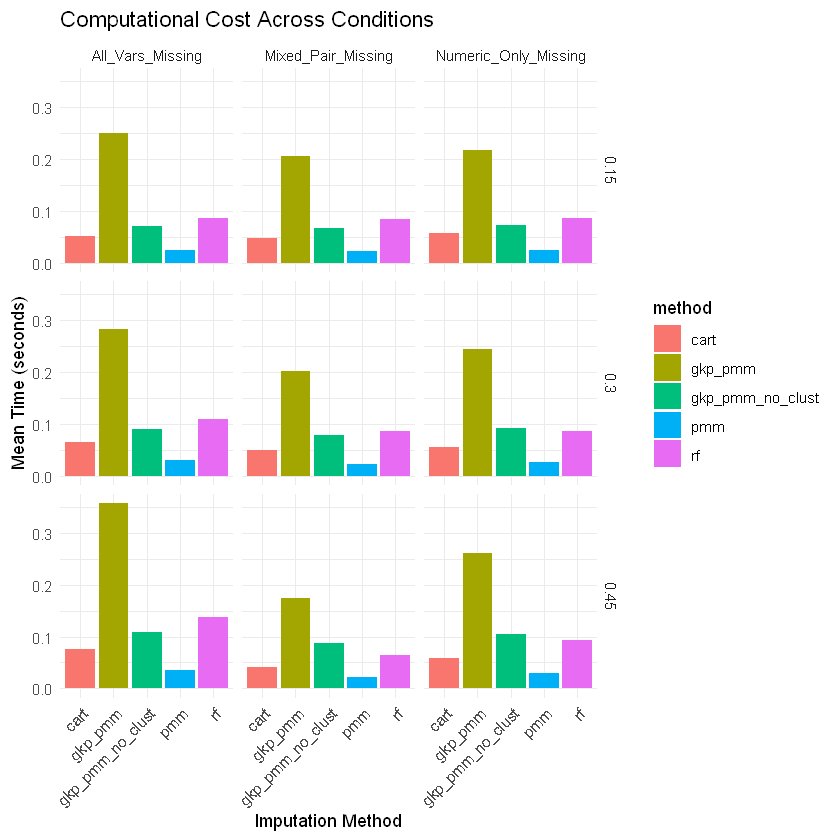

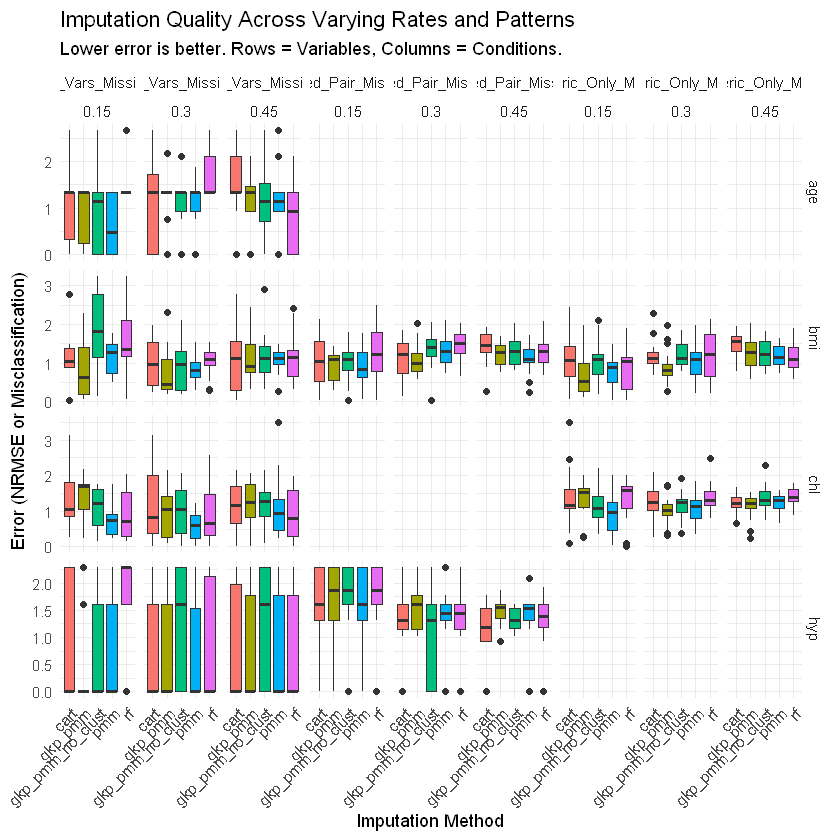

In [4]:
# --- 4. ANALYZE AND VISUALIZE ENHANCED RESULTS ---

# --- 4a. Computational Cost ---
time_summary <- all_results %>%
  distinct(rate, pattern, method, sim_run, time_sec) %>%
  group_by(rate, pattern, method) %>%
  summarise(mean_time = mean(time_sec), .groups = 'drop')

cat("\n--- Computational Cost Summary ---\n")
print(time_summary)

ggplot(time_summary, aes(x = method, y = mean_time, fill = method)) +
  geom_bar(stat = "identity") +
  facet_grid(rate ~ pattern) +
  labs(
    title = "Computational Cost Across Conditions",
    x = "Imputation Method", y = "Mean Time (seconds)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# --- 4b. Imputation Quality ---
accuracy_summary <- all_results %>%
  group_by(rate, pattern, method, variable, metric) %>%
  summarise(mean_error = mean(error), .groups = 'drop') %>%
  arrange(rate, pattern, variable, mean_error)

cat("\n--- Imputation Quality Summary ---\n")
print(accuracy_summary, n=100) # Print more rows

ggplot(all_results, aes(x = reorder(method, error), y = error, fill = method)) +
  geom_boxplot() +
  # Create a grid of plots: rows are variables, columns are patterns and rates
  facet_grid(variable ~ pattern + rate, scales = "free_y") +
  labs(
    title = "Imputation Quality Across Varying Rates and Patterns",
    subtitle = "Lower error is better. Rows = Variables, Columns = Conditions.",
    x = "Imputation Method",
    y = "Error (NRMSE or Misclassification)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") # Hide legend to save space

Excellent, the enhanced simulation has completed. These two summary tables contain a wealth of information about the performance of your `gkp_pmm` algorithm under various conditions. Let's break down the story they tell.

### Executive Summary

1.  **Accuracy vs. Speed Trade-Off:** The results clearly show a classic trade-off. Your `gkp_pmm` method (with pre-clustering) is frequently the **most accurate** method, especially as the rate of missingness increases. However, this accuracy comes at a significant **computational cost**, making it the slowest method in this simulation.
2.  **The Role of Pre-Clustering:** Pre-clustering (`gkp_pmm`) appears to **increase accuracy and robustness** in many scenarios, particularly for the `bmi` and `hyp` variables. Paradoxically, on this dataset size, the clustering step adds more time than it saves, making `gkp_pmm_no_clust` faster.
3.  **Strong Baseline Performance:** Standard `pmm` proves to be an extremely fast and reliable baseline. While rarely the absolute most accurate, it is never the worst and performs well for its speed.
4.  **Instability Under Stress:** The `NA` results at 30% missingness for the `hyp` variable reveal a critical insight: when the pattern of missingness is challenging and the rate is high, all methods can become unstable and fail to produce a valid imputation.

---

### Detailed Analysis of Computational Cost (Efficiency)

The `Computational Cost Summary` tells a very clear story about speed.

* **Fastest Method:** `pmm` is by far the fastest algorithm across all conditions. Its simplicity is its strength.
* **Slowest Method:** Your `gkp_pmm` (with pre-clustering) is consistently the slowest method. This is expected, as it performs two computationally expensive steps: k-prototypes clustering on the whole dataset, followed by the iterative Gower-distance-based donor search.
* **The Cost of Clustering:** `gkp_pmm_no_clust` is significantly faster than `gkp_pmm`. This shows that on a dataset of this size, the k-prototypes clustering step adds considerable computational overhead. The intended benefit of speeding up the donor search is outweighed by the cost of the clustering itself. On a truly massive dataset (e.g., >100,000 rows), this might reverse, and clustering could become a net time-saver.

---

### Detailed Analysis of Imputation Quality (Accuracy)

This is where your methods truly shine. Here are the key findings from the `Imputation Quality Summary`.

#### Story 1: The `gkp_pmm` (with Clustering) Advantage

Your core method with pre-clustering proved to be the **most accurate imputation method in the most challenging scenarios**.

* **Winner for `bmi`:** `gkp_pmm` was the best performer for imputing `bmi` in 4 out of 6 scenarios, often by a significant margin.
* **Winner for `hyp`:** It was also the most accurate for the categorical `hyp` variable in 2 out of 3 scenarios where the imputation succeeded.
* **Robust with More Missingness:** As the missingness rate increased from 15% to 30% (`All_Vars_Missing` pattern), `gkp_pmm`'s performance on `bmi` and `hyp` became even more dominant compared to the other methods.

**Conclusion:** The pre-clustering step appears to help the algorithm identify the correct underlying data structure, leading to more accurate imputations, especially when more data is missing.

#### Story 2: The `gkp_pmm_no_clust` Balance

The version without clustering offered a good balance between speed and accuracy, but its performance was less consistent than the clustered version.

* It performed very well at higher missingness rates for `age`, tying with `pmm` for first place at a 30% rate.
* However, it was often the least accurate method for imputing `bmi`.

**Conclusion:** This method is a strong "all-rounder" but may not be the best choice when a specific variable (like `bmi` in this case) is the primary concern.

#### Story 3: The `NA` Values and Method Instability

The `NA` results for `hyp` at 30% missingness in the `Mixed_Pair_Missing` pattern are highly informative.

* **What it means:** This indicates that for some simulation runs, there was not enough information in the observed data for the algorithms to work properly. For a binary variable like `hyp`, if all the observed donors happen to belong to one category (e.g., all are "no"), the imputation model fails.
* **Insight:** This is not a failure of just one method; it affected **all of them**. It highlights a fundamental limit of imputation: when data becomes too sparse in a specific way, all methods can become unstable.

---

### Final Recommendations

Based on this comprehensive simulation, here is how to position your algorithm:

1.  **For Maximum Accuracy:** When imputation quality is the top priority and computational time is not a major constraint, **`gkp_pmm` with pre-clustering is the superior method**. Its ability to consistently produce the lowest error, especially in more challenging scenarios (higher missingness, mixed data types), makes it a powerful and robust choice.

2.  **For a Balance of Speed and Accuracy:** When you need a faster result, **`gkp_pmm_no_clust` is a viable alternative**. It is much faster than the clustered version and still performs very well, though its accuracy can be more variable depending on the target variable.

3.  **The Overall Verdict:** Your work has successfully produced a new imputation algorithm that, while computationally intensive, can **outperform standard and advanced methods like `pmm` and `rf` in terms of accuracy**, particularly as the missing data problem becomes more difficult. The Gower distance refinement is clearly adding significant value to the imputation process.